# Unet on Male Dataset of CelebA

## Making directories

In [ ]:
!mkdir "/content/data/"
!mkdir "/content/data/train/"
!mkdir "/content/data/test/"
!mkdir "/content/data/train/dataset/"
!mkdir "/content/data/test/dataset/"

## Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/model_male/'

Mounted at /content/drive


## Collecting Data and preprocessing

In [ ]:
!gdown --id 1_F8l2n2JF7wDNpOaBsCDzCoaLbVqDZ49

Downloading...
From: https://drive.google.com/uc?id=1_F8l2n2JF7wDNpOaBsCDzCoaLbVqDZ49
To: /content/archive.zip
1.43GB [00:15, 90.5MB/s]


In [ ]:
!unzip /content/archive.zip

In [ ]:
import pandas as pd

df = pd.read_csv('/content/list_attr_celeba.csv')

In [ ]:
male_array=[]
female_array=[]
for i in range(len(df)):
  if df["Male"][i]==1:
    male_array.append(df["image_id"][i])
  else:
    female_array.append(df["image_id"][i])



In [ ]:
!mkdir "/content/male_dataset"

In [ ]:
import shutil
for i in range(len(male_array)):
  folder_name='/content/img_align_celeba/img_align_celeba'
  temp=folder_name+"/"+male_array[i]
  temp2="/content/male_dataset"
  shutil.move(temp, temp2)
  print(i)

In [ ]:
!mkdir "/content/male_dataset_resized"

In [ ]:
from PIL import Image  
def image_resize(location,newlocation):
  i=0
  for count, filename in enumerate(os.listdir(location)):
      src = location +'/'+ filename
      im = Image.open(src)
      newsize = (256, 256)
      im1 = im.resize(newsize)
      new=newlocation+"/"+filename
      im1.save(new)
      i+=1
      print(i)

In [ ]:
import os
image_resize("/content/male_dataset","/content/male_dataset_resized")

## Data Splitting in test and train

In [ ]:
import os
import random
import shutil

src_dir = "/content/male_dataset_resized/"
dest_dir_train = "/content/data/train/dataset/"
dest_dir_test = "/content/data/test/dataset/"

cnt = 0
files = os.listdir(src_dir)
random.shuffle(files)
i=0
for count, filename in enumerate(files):
    i+=1
    src = src_dir + filename
    data_size =  84433
    if (data_size*0.8) > cnt:
        des = dest_dir_train
    elif i!=data_size:
        des = dest_dir_test
    else:
        break
    dest = shutil.copy(src, des)
    cnt += 1

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2

In [ ]:
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(
        "/content/data/train/", target_size = (256, 256),color_mode = "rgb", batch_size=50,class_mode = "input")

Found 67547 images belonging to 1 classes.


In [ ]:
test_datagen = ImageDataGenerator()
test_generator = train_datagen.flow_from_directory(
        "/content/data/test/", target_size = (256, 256),color_mode = "rgb", batch_size=50,class_mode = "input")

Found 16885 images belonging to 1 classes.


## Metric

In [ ]:
def dice_coefficient(y_true, y_pred):
    y_true_flattened = keras.backend.flatten(y_true)
    y_pred_flattened = keras.backend.flatten(y_pred)
    x = keras.backend.sum(y_true_flattened * y_pred_flattened)
    y=keras.backend.sum(y_true_flattened + y_pred_flattened)
    return 2*x/y

## Model

In [ ]:
# Model

class Generator():
  # UNET model
  def train_model(self, input_size=(256,256,3)):
    inputs = keras.layers.Input(input_size)
    acti_function = "relu"
    padding = "same"
    filters = 32
    kernel_size = (3,3)
    pool_size = (2,2)
    up_kernel = (2,2)
    up_stride = (2,2)
    # encoder 
    conv1, pooling1 = self.Convulation_layer(filters,kernel_size, pool_size, acti_function, padding, inputs)
    conv2, pooling2 = self.Convulation_layer(filters*2, kernel_size, pool_size, acti_function, padding, pooling1)
    conv3, pooling3 = self.Convulation_layer(filters*4, kernel_size, pool_size, acti_function,padding, pooling2) 
    conv4, pooling4 = self.Convulation_layer(filters*8, kernel_size, pool_size, acti_function,padding, pooling3) 
    # decoder 
    conv5, up6 = self.Up_Convulation_layer(filters*16, filters*8, kernel_size, up_kernel, up_stride, acti_function, padding, pooling4, conv4)
    conv6, up7 = self.Up_Convulation_layer(filters*8, filters*4, kernel_size, up_kernel, up_stride, acti_function,padding, up6, conv3)
    conv7, up8 = self.Up_Convulation_layer(filters*4, filters*2, kernel_size, up_kernel, up_stride, acti_function, padding, up7, conv2)
    conv8, up9 = self.Up_Convulation_layer(filters*2,filters, kernel_size, up_kernel, up_stride, acti_function,padding, up8, conv1)
    conv9 = keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(up9)
    conv9 = keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(conv9)
    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)
    return keras.models.Model(inputs=[inputs], outputs=[outputs]) 
    
  def Convulation_layer(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    pooling = keras.layers.MaxPooling2D(pool_size)(conv)
    return conv, pooling

  def Up_Convulation_layer(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)
    return conv, up

In [ ]:
keras.backend.clear_session()
model = Generator().train_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coefficient])

In [ ]:
def createmask(img,mask):
  img = img.astype(np.uint8)
  masked_image = np.copy(img)
  for l in range(len(img)):
    masked_image[l] = cv2.bitwise_and(img[l], mask)
  return masked_image/255

## Training Model

In [ ]:
import sys
epochs = 4
rows = 5

num_images = int(data_size*0.8) #67000
batch_size = 50
fp = open(drive_path + "logs.txt","a")
for epoch in range(epochs):
  cnt = 0
  print("============================== Epoch"+str(epoch)+"===============================")
  for x,y in train_generator:
    mask = np.full((256,256,3), 255, np.uint8)
    mask_len = 64
    x_mask = random.randint(50,256-mask_len-50)
    y_mask = random.randint(50,256-mask_len-50)
    for i in range(3):
        for j in range(256):
            for k in range(256):
                if j>x_mask and x_mask+mask_len>j and k>y_mask and y_mask+mask_len>k:
                    mask[j][k][i] = 1
    x_mask = createmask(x,mask)
    orignal = sys.stdout
    # logs are wriiten in drive. This is accompilished by altering file descripters.
    sys.stdout = fp
    model.fit(x_mask,y/255,batch_size = batch_size)
    # Reseting stdout file descripter 
    sys.stdout = orignal
    cnt += 1
    if (cnt == num_images // batch_size):
      break
  model.save_weights(drive_path+str(epoch)+".h5")

============================== Epoch0===============================
============================== Epoch1===============================
============================== Epoch2===============================
============================== Epoch3===============================


## Testing 

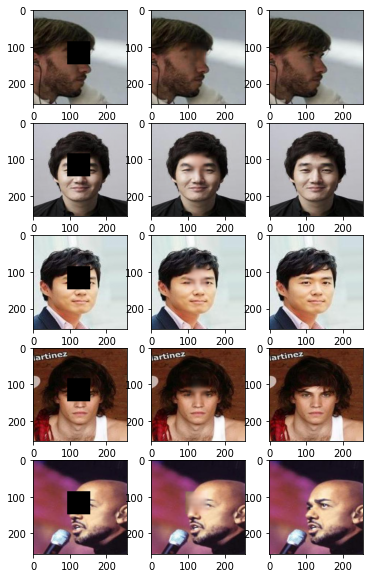

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=rows, ncols=3, figsize=(6, 2*rows))
for x,y in test_generator:
  x_mask = createmask(x,mask)
  y_hat = model.predict(x_mask)
  for i in range(5):
    ax[i][0].imshow(x_mask[i])
    ax[i][1].imshow(y_hat[i])
    ax[i][2].imshow(y[i]/255)
  break
plt.show()